In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np

# Read the head and mat files with path
def find_challenge_files(data_directory):
    header_files = list()
    recording_files = list()
    for f in sorted(os.listdir(data_directory)):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

# Load the head file into a string
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

# Get frequency from header.
def get_frequency(header):
    frequency = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency

# Get the labels from header
def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('# Dx') or l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass

    # atrial fibrillation	164889003 -> 0 AF
    if '164889003' in labels:
      return 0

    # sinus rhythm 426783006 -> 1 NSR
    elif '426783006' in labels:
      return 1

    # sinus bradycardia	426177001 SB
    else:
      return 2

# Load the recording file as an array.
# Default 12 leads
def load_recording(recording_file, leads=None, key='val'):
    from scipy.io import loadmat
    recording = loadmat(recording_file)[key]
    if leads == 6:
      recording = recording[:6, :]
    return recording


# Get leads from header.
def get_leads(header):
    leads = list()
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            leads.append(entries[-1])
        else:
            break
    return tuple(leads)

In [3]:
# Get the two list header_files and recording_files
lst = ['g' + str(i) for i in range(1, 12)]

header_files = []
recording_files = []

for i in range(len(lst)):
  address = '/content/drive/MyDrive/data_temp/chapman_shaoxing/' + lst[i]
  head, rec = find_challenge_files(address)
  header_files.extend(head)
  recording_files.extend(rec)

In [4]:
header_files[0]

'/content/drive/MyDrive/data_temp/chapman_shaoxing/g1/JS00001.hea'

In [5]:
## Balance the dataset

af_header = []
af_record = []
nsr_header = []
nsr_record = []
other_header = []
other_record = []

for i in range(len(recording_files)):

  ecg = load_header(header_files[i])
  if get_labels(ecg) == 0:
    af_header.append(header_files[i])
    af_record.append(recording_files[i])
  elif get_labels(ecg) == 1:
    nsr_header.append(header_files[i])
    nsr_record.append(recording_files[i])
  else:
    other_header.append(header_files[i])
    other_record.append(recording_files[i])

In [6]:
len(af_record),len(nsr_header),len(other_header)

(1780, 1826, 6641)

In [7]:
import random

# 从0到8021中随机选择1800个数字
sampled_numbers = random.sample(range(6641), 1800)

# sampled_numbers 就是随机选择的1800个数字组成的列表
len(sampled_numbers)

1800

In [8]:
header_files = af_header + nsr_header
recording_files = af_record + nsr_record

for i in sampled_numbers:
  header_files.append(other_header[i])
  recording_files.append(other_record[i])

len(header_files)

5406

In [9]:
random_indices = random.sample(range(len(header_files)), len(header_files))

# 根据随机索引重新排列两个列表
shuffled_header = [header_files[i] for i in random_indices]
shuffled_record = [recording_files[i] for i in random_indices]

In [10]:
header_files = shuffled_header
recording_files = shuffled_record

In [11]:
# 小波去噪
import pywt
import numpy as np

def denoise_ecg(ecg_data):
    # 小波去噪参数
    wavelet = 'db4'  # 选择小波基函数
    level = 3  # 小波分解的层数

    # 创建一个一样大小的数组
    denoised_ecg = np.zeros_like(ecg_data)

    for i in range(ecg_data.shape[0]):
        # 对每个导联的心电图信号进行小波分解
        coeffs = pywt.wavedec(ecg_data[i], wavelet, level=level)

        # 根据阈值去除噪声
        threshold = np.std(coeffs[-level]) * np.sqrt(2 * np.log(len(ecg_data[i])))
        coeffs[1:] = (pywt.threshold(c, threshold) for c in coeffs[1:])

        # 重构信号
        denoised_ecg[i] = pywt.waverec(coeffs, wavelet)

    return denoised_ecg

In [12]:
# Heartbeat segmentation
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def get_peak(ecg_data):

  fs = 500
  # Choose the second lead for R peak
  lead = ecg_data[1]
  threshold = 0.7 * np.max(lead)
  distance = int(0.5 * fs)   # the min distance between two peaks

  peaks, _ = find_peaks(lead, height=threshold, distance=distance)

  # Choose the second peak
  peaks = peaks.tolist()
  if len(peaks) > 1:
    return peaks[1]
  elif len(peaks) == 1:
    return peaks[0]
  else:
    return 0

def segment(ecg_data):
  peak = get_peak(ecg_data)
  selected_data = []
  min_length = 400
  for lead_data in ecg_data:
    if peak <150:
      selected_lead_data = lead_data[ : min_length]
    elif peak >= 4750:
      selected_lead_data = lead_data[4999 - min_length : 4999]
    else:
      selected_lead_data = lead_data[peak - 150:peak + 250]
    selected_data.append(selected_lead_data)

  # Change selected_data into array (6,400)
  selected_data = np.array(selected_data)
  return selected_data

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch

class MyDataset(Dataset):
    def __init__(self, recording_files, header_files):
        self.recording_files = recording_files
        self.header_files = header_files

    def __len__(self):
        return len(self.recording_files)

    def __getitem__(self, index):
        recording_file = self.recording_files[index]
        header_file = self.header_files[index]

        # Load the data with 6 leads
        raw_data = load_recording(recording_file, leads= 12)
        denoise_data = denoise_ecg(raw_data)
        segment_data = segment(denoise_data)
        ecg_data = torch.tensor(segment_data, dtype=torch.float)

        # Load the label
        label = get_labels(load_header(header_file))

        return ecg_data, label


# Define batch size
batch_size = 64
categroy = 3

In [18]:
import torch.optim as optim
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=20, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=20, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=10, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(1216, 64) # 2720
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32) # 32 * 98 = 3136
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 创建模型实例
model = CNN()

# 统计模型参数总数
total_params = count_parameters(model)
print(f"number of parameters: {total_params}")

number of parameters: 118563


In [ ]:
# CNN LSTM
import torch
import torch.nn as nn
import torch.optim as optim

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(12, 16, kernel_size=20, stride=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=10, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(16, 16, kernel_size=5, stride=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=256)
        self.fc4 = nn.Linear(256, 20)
        self.dropout4 = nn.Dropout(p=0.2)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(20, 5)
        self.dropout5 = nn.Dropout(p=0.2)
        self.relu5 = nn.ReLU()

        self.fc6 = nn.Linear(215, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.fc4(x)
        x = self.dropout4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.dropout5(x)
        x = self.relu5(x)
        x = x.view(x.size(0),-1)
        x = self.fc6(x)
        return x

model = CNN_LSTM()

# 统计模型参数总数
total_params = count_parameters(model)
print(f"number of parameters: {total_params}")

number of parameters: 294197


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def train_model(model, criterion, optimizer, num_epochs, k_folds, dataset):


  # 将数据集分为 k_folds 折
  kf = KFold(n_splits=k_folds, shuffle=True)
  for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):

    print(f"Fold {fold+1}")
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_subset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for inputs, labels in train_loader:

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = total_correct / total_samples

        model.eval()  # 切换到评估模式
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for test_inputs, test_labels in val_loader:

                test_outputs = model(test_inputs)
                val_loss += criterion(test_outputs, test_labels).item()

                _, test_predicted = torch.max(test_outputs, 1)
                val_correct += (test_predicted == test_labels).sum().item()
                val_total += test_labels.size(0)


        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)



        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2%}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}")

    plt.figure(figsize=(10, 6))

    # 绘制训练集损失和测试集损失
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练集准确率和测试集准确率
    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Fold 1


/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Epoch [1/10], Train Loss: 2.7755, Train Accuracy: 38.91%, Val Loss: 1.0324, Val Accuracy: 45.20%
Epoch [2/10], Train Loss: 1.0448, Train Accuracy: 46.72%, Val Loss: 0.9875, Val Accuracy: 51.21%
Epoch [3/10], Train Loss: 1.0059, Train Accuracy: 50.13%, Val Loss: 0.9765, Val Accuracy: 50.17%
Epoch [4/10], Train Loss: 0.9828, Train Accuracy: 52.62%, Val Loss: 0.9563, Val Accuracy: 53.29%
Epoch [5/10], Train Loss: 0.9782, Train Accuracy: 52.01%, Val Loss: 0.9357, Val Accuracy: 55.49%
Epoch [6/10], Train Loss: 0.9760, Train Accuracy: 52.65%, Val Loss: 0.9157, Val Accuracy: 55.84%
Epoch [7/10], Train Loss: 0.9849, Train Accuracy: 52.12%, Val Loss: 1.0085, Val Accuracy: 45.55%
Epoch [8/10], Train Loss: 1.1188, Train Accuracy: 35.85%, Val Loss: 1.0630, Val Accuracy: 44.62%
Epoch [9/10], Train Loss: 1.0755, Train Accuracy: 45.24%, Val Loss: 1.0208, Val Accuracy: 49.94%
Epoch [10/10], Train Loss: 0.9998, Train Accuracy: 50.13%, Val Loss: 0.9990, Val Accuracy: 47.86%


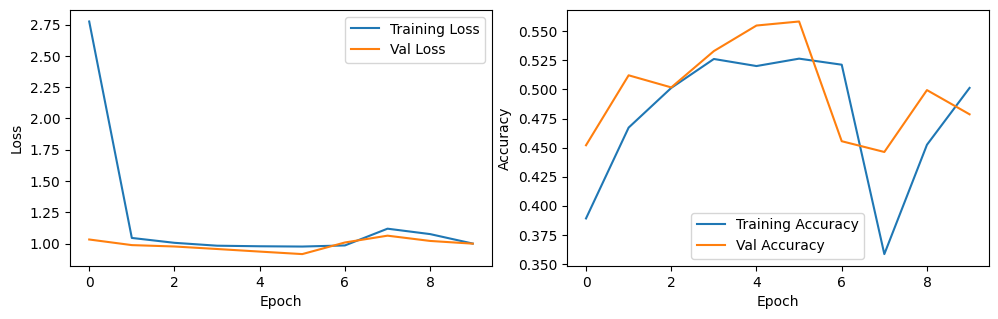

Fold 2
Epoch [1/10], Train Loss: 0.9805, Train Accuracy: 50.51%, Val Loss: 0.9780, Val Accuracy: 54.45%
Epoch [2/10], Train Loss: 0.9603, Train Accuracy: 53.71%, Val Loss: 0.9712, Val Accuracy: 52.95%
Epoch [3/10], Train Loss: 0.9433, Train Accuracy: 53.83%, Val Loss: 1.0185, Val Accuracy: 55.03%
Epoch [4/10], Train Loss: 0.9442, Train Accuracy: 53.14%, Val Loss: 1.0299, Val Accuracy: 54.22%
Epoch [5/10], Train Loss: 0.9388, Train Accuracy: 55.45%, Val Loss: 1.0244, Val Accuracy: 46.24%
Epoch [6/10], Train Loss: 0.9479, Train Accuracy: 53.71%, Val Loss: 0.9706, Val Accuracy: 53.76%
Epoch [7/10], Train Loss: 0.8973, Train Accuracy: 55.51%, Val Loss: 0.9720, Val Accuracy: 52.60%
Epoch [8/10], Train Loss: 0.9244, Train Accuracy: 54.50%, Val Loss: 0.9963, Val Accuracy: 50.98%
Epoch [9/10], Train Loss: 0.9145, Train Accuracy: 54.12%, Val Loss: 0.9747, Val Accuracy: 55.03%
Epoch [10/10], Train Loss: 0.8995, Train Accuracy: 55.97%, Val Loss: 0.9833, Val Accuracy: 54.80%


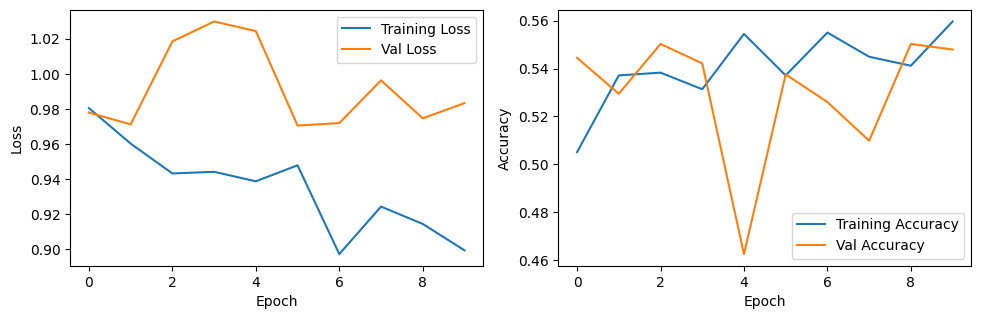

Fold 3
Epoch [1/10], Train Loss: 0.9116, Train Accuracy: 55.91%, Val Loss: 0.8839, Val Accuracy: 60.00%
Epoch [2/10], Train Loss: 0.8889, Train Accuracy: 60.08%, Val Loss: 0.8961, Val Accuracy: 58.15%
Epoch [3/10], Train Loss: 0.8746, Train Accuracy: 59.70%, Val Loss: 0.8672, Val Accuracy: 64.05%
Epoch [4/10], Train Loss: 0.8741, Train Accuracy: 59.93%, Val Loss: 0.8745, Val Accuracy: 60.35%
Epoch [5/10], Train Loss: 0.8424, Train Accuracy: 61.29%, Val Loss: 0.8466, Val Accuracy: 65.09%
Epoch [6/10], Train Loss: 0.8204, Train Accuracy: 64.09%, Val Loss: 0.9252, Val Accuracy: 56.76%
Epoch [7/10], Train Loss: 0.8321, Train Accuracy: 62.65%, Val Loss: 0.8599, Val Accuracy: 64.39%
Epoch [8/10], Train Loss: 0.7872, Train Accuracy: 65.25%, Val Loss: 0.8817, Val Accuracy: 61.27%
Epoch [9/10], Train Loss: 0.7644, Train Accuracy: 66.52%, Val Loss: 0.8622, Val Accuracy: 64.97%
Epoch [10/10], Train Loss: 0.7883, Train Accuracy: 65.71%, Val Loss: 0.9006, Val Accuracy: 61.50%


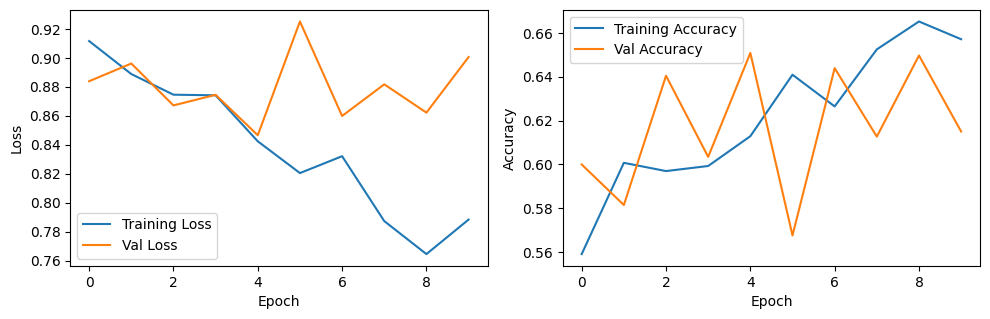

Fold 4
Epoch [1/10], Train Loss: 0.8119, Train Accuracy: 65.45%, Val Loss: 0.8441, Val Accuracy: 59.88%
Epoch [2/10], Train Loss: 0.8272, Train Accuracy: 64.56%, Val Loss: 0.8351, Val Accuracy: 64.16%
Epoch [3/10], Train Loss: 0.8590, Train Accuracy: 61.95%, Val Loss: 0.7897, Val Accuracy: 64.05%
Epoch [4/10], Train Loss: 0.8007, Train Accuracy: 65.45%, Val Loss: 0.7669, Val Accuracy: 66.47%
Epoch [5/10], Train Loss: 0.7647, Train Accuracy: 66.61%, Val Loss: 0.7743, Val Accuracy: 66.36%
Epoch [6/10], Train Loss: 0.7275, Train Accuracy: 68.60%, Val Loss: 0.7915, Val Accuracy: 64.05%
Epoch [7/10], Train Loss: 0.7152, Train Accuracy: 69.36%, Val Loss: 0.8011, Val Accuracy: 65.20%
Epoch [8/10], Train Loss: 0.6850, Train Accuracy: 70.83%, Val Loss: 0.8551, Val Accuracy: 64.74%
Epoch [9/10], Train Loss: 0.6984, Train Accuracy: 69.90%, Val Loss: 0.8120, Val Accuracy: 65.78%
Epoch [10/10], Train Loss: 0.6422, Train Accuracy: 71.26%, Val Loss: 0.8921, Val Accuracy: 66.71%


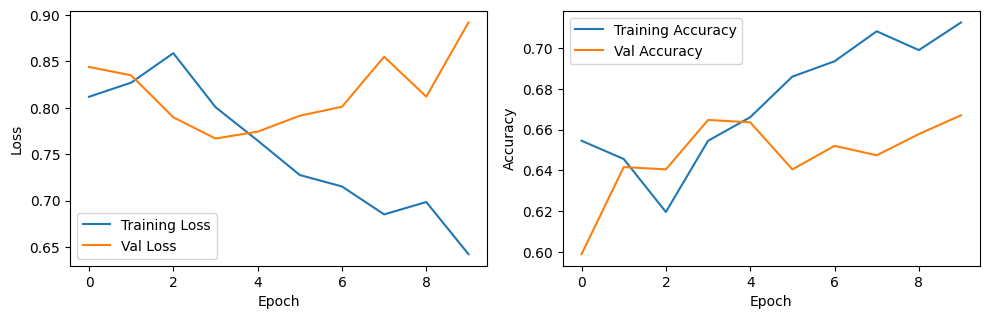

Fold 5
Epoch [1/10], Train Loss: 0.7106, Train Accuracy: 70.55%, Val Loss: 0.6801, Val Accuracy: 69.10%
Epoch [2/10], Train Loss: 0.7490, Train Accuracy: 68.64%, Val Loss: 0.6983, Val Accuracy: 69.68%
Epoch [3/10], Train Loss: 0.6830, Train Accuracy: 70.69%, Val Loss: 0.6814, Val Accuracy: 72.22%
Epoch [4/10], Train Loss: 0.6332, Train Accuracy: 72.60%, Val Loss: 0.6824, Val Accuracy: 70.95%
Epoch [5/10], Train Loss: 0.6252, Train Accuracy: 73.35%, Val Loss: 0.6818, Val Accuracy: 70.37%
Epoch [6/10], Train Loss: 0.5912, Train Accuracy: 75.20%, Val Loss: 0.6928, Val Accuracy: 72.22%
Epoch [7/10], Train Loss: 0.5981, Train Accuracy: 74.71%, Val Loss: 0.7010, Val Accuracy: 70.95%
Epoch [8/10], Train Loss: 0.5572, Train Accuracy: 76.65%, Val Loss: 0.7395, Val Accuracy: 70.25%
Epoch [9/10], Train Loss: 0.5423, Train Accuracy: 77.72%, Val Loss: 0.7597, Val Accuracy: 70.60%
Epoch [10/10], Train Loss: 0.5421, Train Accuracy: 77.05%, Val Loss: 0.7702, Val Accuracy: 71.30%


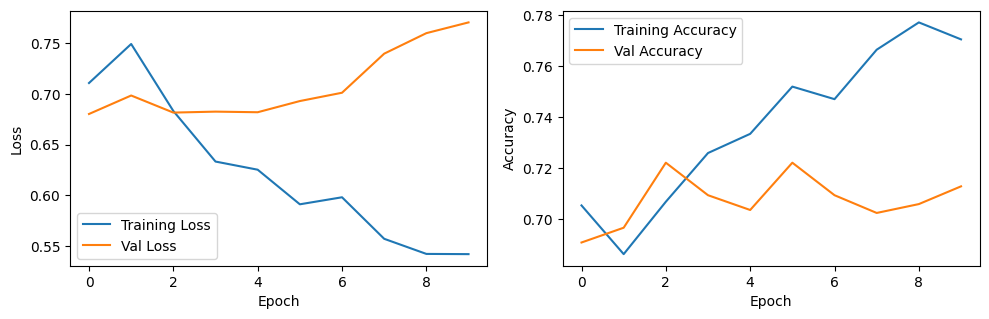

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
k_folds = 5
num_recordings = len(recording_files)
split_point = int(0.8 * num_recordings)

train_recording = recording_files[:split_point]
test_recording = recording_files[split_point:]
train_header = header_files[:split_point]
test_header = header_files[split_point:]
dataset = MyDataset(train_recording, train_header)
test_dataset = MyDataset(test_recording, test_header)
train_model(model, criterion, optimizer, num_epochs, k_folds, dataset)

In [ ]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report
y_pred_list = []
y_true_list = []
testloader = DataLoader(test_dataset, batch_size=batch_size)
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

import numpy as np
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
print(classification_report(y_true, y_pred))

  0%|          | 0/17 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       327
           1       0.67      0.72      0.70       379
           2       0.65      0.59      0.62       376

    accuracy                           0.68      1082
   macro avg       0.68      0.68      0.68      1082
weighted avg       0.68      0.68      0.68      1082



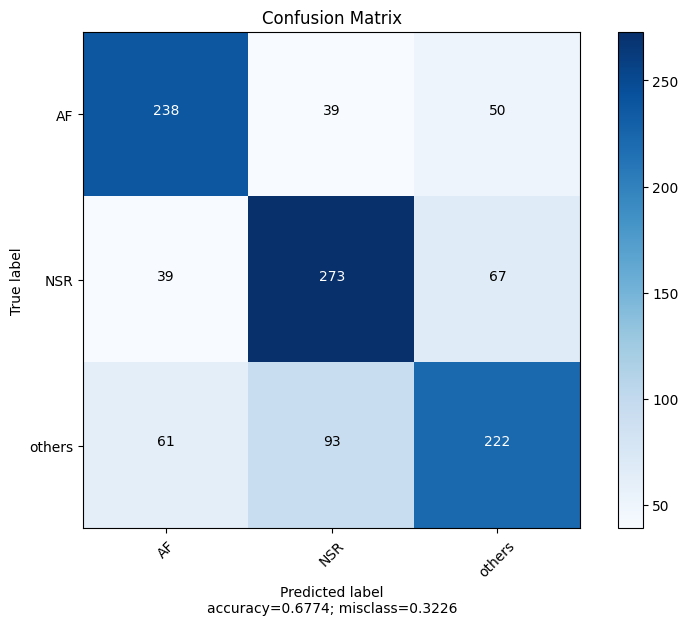

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['AF','NSR','others'],
                      title        = "Confusion Matrix")

Fold 1


/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Epoch [1/10], Train Loss: 1.0406, Train Accuracy: 46.40%, Val Loss: 0.8856, Val Accuracy: 60.23%
Epoch [2/10], Train Loss: 0.7995, Train Accuracy: 64.06%, Val Loss: 0.6987, Val Accuracy: 70.29%
Epoch [3/10], Train Loss: 0.7342, Train Accuracy: 69.90%, Val Loss: 0.6494, Val Accuracy: 73.29%
Epoch [4/10], Train Loss: 0.6704, Train Accuracy: 72.65%, Val Loss: 0.6361, Val Accuracy: 73.29%
Epoch [5/10], Train Loss: 0.6299, Train Accuracy: 74.15%, Val Loss: 0.6280, Val Accuracy: 72.37%
Epoch [6/10], Train Loss: 0.5995, Train Accuracy: 74.56%, Val Loss: 0.6073, Val Accuracy: 74.91%
Epoch [7/10], Train Loss: 0.5908, Train Accuracy: 75.51%, Val Loss: 0.5824, Val Accuracy: 76.30%
Epoch [8/10], Train Loss: 0.5814, Train Accuracy: 76.15%, Val Loss: 0.5822, Val Accuracy: 76.07%
Epoch [9/10], Train Loss: 0.5597, Train Accuracy: 76.76%, Val Loss: 0.5745, Val Accuracy: 76.53%
Epoch [10/10], Train Loss: 0.5466, Train Accuracy: 77.85%, Val Loss: 0.5741, Val Accuracy: 76.42%


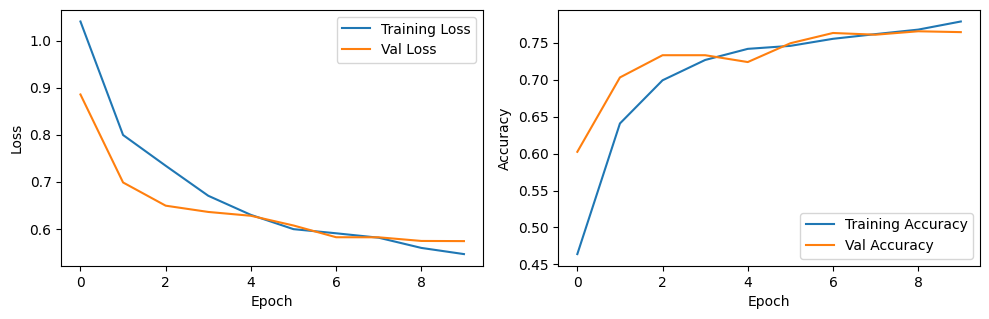

Fold 2
Epoch [1/10], Train Loss: 0.5719, Train Accuracy: 76.84%, Val Loss: 0.5198, Val Accuracy: 78.03%
Epoch [2/10], Train Loss: 0.5605, Train Accuracy: 76.58%, Val Loss: 0.5086, Val Accuracy: 78.73%
Epoch [3/10], Train Loss: 0.5537, Train Accuracy: 77.80%, Val Loss: 0.5248, Val Accuracy: 78.38%
Epoch [4/10], Train Loss: 0.5520, Train Accuracy: 78.14%, Val Loss: 0.5332, Val Accuracy: 78.50%
Epoch [5/10], Train Loss: 0.5317, Train Accuracy: 78.72%, Val Loss: 0.5157, Val Accuracy: 78.03%
Epoch [6/10], Train Loss: 0.5175, Train Accuracy: 78.26%, Val Loss: 0.5119, Val Accuracy: 78.73%
Epoch [7/10], Train Loss: 0.5032, Train Accuracy: 79.18%, Val Loss: 0.5412, Val Accuracy: 76.53%
Epoch [8/10], Train Loss: 0.5237, Train Accuracy: 79.42%, Val Loss: 0.5129, Val Accuracy: 78.73%
Epoch [9/10], Train Loss: 0.5237, Train Accuracy: 78.26%, Val Loss: 0.5868, Val Accuracy: 74.45%
Epoch [10/10], Train Loss: 0.5233, Train Accuracy: 78.98%, Val Loss: 0.5105, Val Accuracy: 78.96%


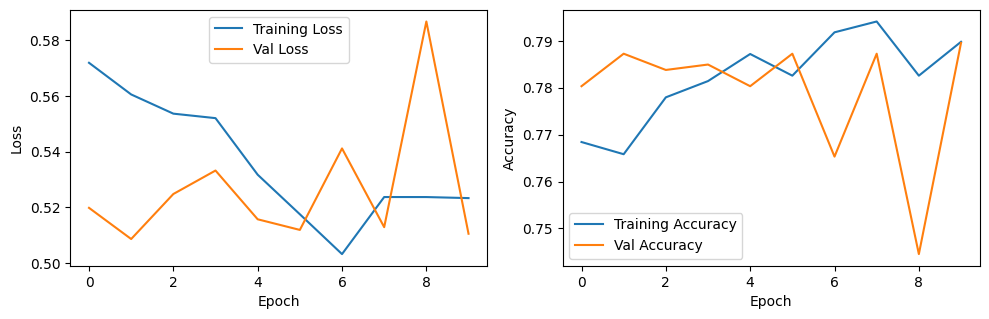

Fold 3
Epoch [1/10], Train Loss: 0.5256, Train Accuracy: 78.72%, Val Loss: 0.4735, Val Accuracy: 82.66%
Epoch [2/10], Train Loss: 0.5186, Train Accuracy: 78.46%, Val Loss: 0.5384, Val Accuracy: 79.08%
Epoch [3/10], Train Loss: 0.5109, Train Accuracy: 78.98%, Val Loss: 0.4838, Val Accuracy: 80.00%
Epoch [4/10], Train Loss: 0.5007, Train Accuracy: 79.47%, Val Loss: 0.4723, Val Accuracy: 80.58%
Epoch [5/10], Train Loss: 0.5037, Train Accuracy: 80.28%, Val Loss: 0.5170, Val Accuracy: 79.19%
Epoch [6/10], Train Loss: 0.5114, Train Accuracy: 78.78%, Val Loss: 0.4880, Val Accuracy: 80.58%
Epoch [7/10], Train Loss: 0.4866, Train Accuracy: 79.71%, Val Loss: 0.4803, Val Accuracy: 80.12%
Epoch [8/10], Train Loss: 0.4941, Train Accuracy: 80.20%, Val Loss: 0.4862, Val Accuracy: 80.35%
Epoch [9/10], Train Loss: 0.4913, Train Accuracy: 80.08%, Val Loss: 0.4998, Val Accuracy: 79.65%
Epoch [10/10], Train Loss: 0.5070, Train Accuracy: 79.53%, Val Loss: 0.5026, Val Accuracy: 77.92%


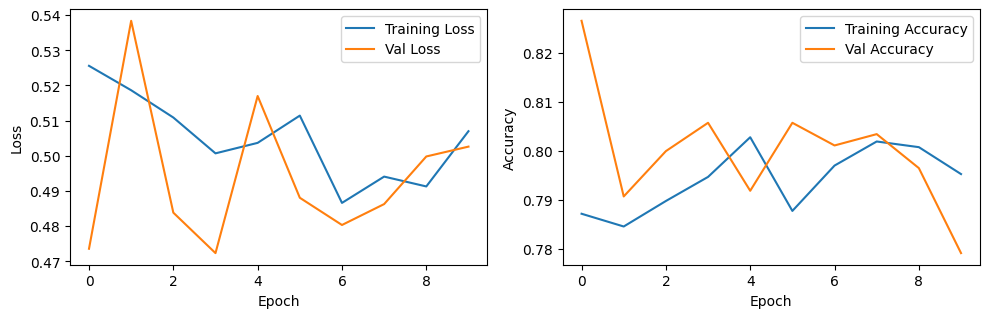

Fold 4
Epoch [1/10], Train Loss: 0.5551, Train Accuracy: 77.33%, Val Loss: 0.5093, Val Accuracy: 78.50%
Epoch [2/10], Train Loss: 0.5191, Train Accuracy: 79.47%, Val Loss: 0.4699, Val Accuracy: 82.20%
Epoch [3/10], Train Loss: 0.5221, Train Accuracy: 79.33%, Val Loss: 0.4725, Val Accuracy: 82.43%
Epoch [4/10], Train Loss: 0.5080, Train Accuracy: 79.27%, Val Loss: 0.4685, Val Accuracy: 81.50%
Epoch [5/10], Train Loss: 0.4884, Train Accuracy: 80.72%, Val Loss: 0.4742, Val Accuracy: 80.58%
Epoch [6/10], Train Loss: 0.4667, Train Accuracy: 80.63%, Val Loss: 0.4748, Val Accuracy: 81.85%
Epoch [7/10], Train Loss: 0.4649, Train Accuracy: 80.86%, Val Loss: 0.4766, Val Accuracy: 81.16%
Epoch [8/10], Train Loss: 0.4884, Train Accuracy: 80.57%, Val Loss: 0.4946, Val Accuracy: 80.35%
Epoch [9/10], Train Loss: 0.4744, Train Accuracy: 81.01%, Val Loss: 0.4961, Val Accuracy: 80.35%
Epoch [10/10], Train Loss: 0.4737, Train Accuracy: 81.41%, Val Loss: 0.4798, Val Accuracy: 80.23%


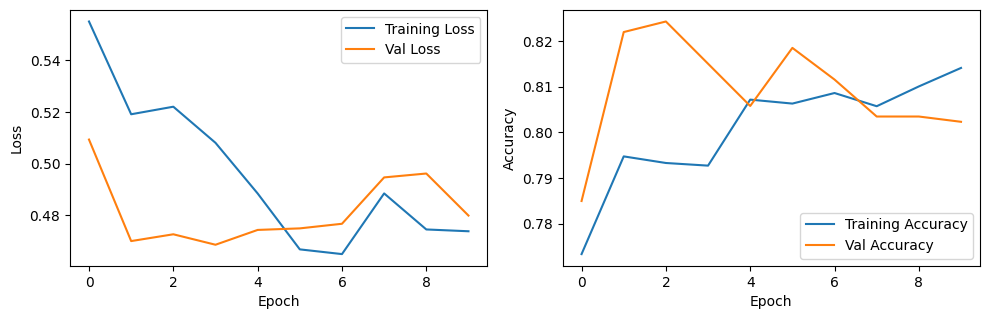

Fold 5
Epoch [1/10], Train Loss: 0.4829, Train Accuracy: 80.06%, Val Loss: 0.5040, Val Accuracy: 78.70%
Epoch [2/10], Train Loss: 0.4750, Train Accuracy: 81.76%, Val Loss: 0.4853, Val Accuracy: 79.17%
Epoch [3/10], Train Loss: 0.4474, Train Accuracy: 82.31%, Val Loss: 0.5181, Val Accuracy: 77.78%
Epoch [4/10], Train Loss: 0.4527, Train Accuracy: 81.30%, Val Loss: 0.4841, Val Accuracy: 80.32%
Epoch [5/10], Train Loss: 0.4473, Train Accuracy: 81.82%, Val Loss: 0.5177, Val Accuracy: 78.36%
Epoch [6/10], Train Loss: 0.4507, Train Accuracy: 83.03%, Val Loss: 0.4941, Val Accuracy: 79.86%
Epoch [7/10], Train Loss: 0.4557, Train Accuracy: 81.97%, Val Loss: 0.5251, Val Accuracy: 78.70%
Epoch [8/10], Train Loss: 0.4480, Train Accuracy: 82.23%, Val Loss: 0.5119, Val Accuracy: 79.28%
Epoch [9/10], Train Loss: 0.4211, Train Accuracy: 83.41%, Val Loss: 0.5247, Val Accuracy: 79.28%
Epoch [10/10], Train Loss: 0.4471, Train Accuracy: 81.94%, Val Loss: 0.5306, Val Accuracy: 78.24%


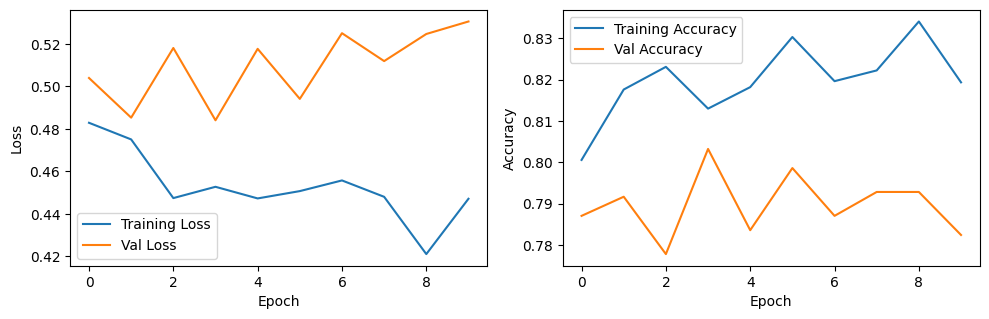

In [ ]:
model = CNN_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
k_folds = 5
num_recordings = len(recording_files)
split_point = int(0.8 * num_recordings)

train_recording = recording_files[:split_point]
test_recording = recording_files[split_point:]
train_header = header_files[:split_point]
test_header = header_files[split_point:]
dataset = MyDataset(train_recording, train_header)
test_dataset = MyDataset(test_recording, test_header)
train_model(model, criterion, optimizer, num_epochs, k_folds, dataset)

In [ ]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report
y_pred_list = []
y_true_list = []
testloader = DataLoader(test_dataset, batch_size=batch_size)
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

import numpy as np
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
print(classification_report(y_true, y_pred))

  0%|          | 0/17 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       327
           1       0.77      0.82      0.79       379
           2       0.78      0.68      0.73       376

    accuracy                           0.78      1082
   macro avg       0.78      0.78      0.78      1082
weighted avg       0.78      0.78      0.78      1082



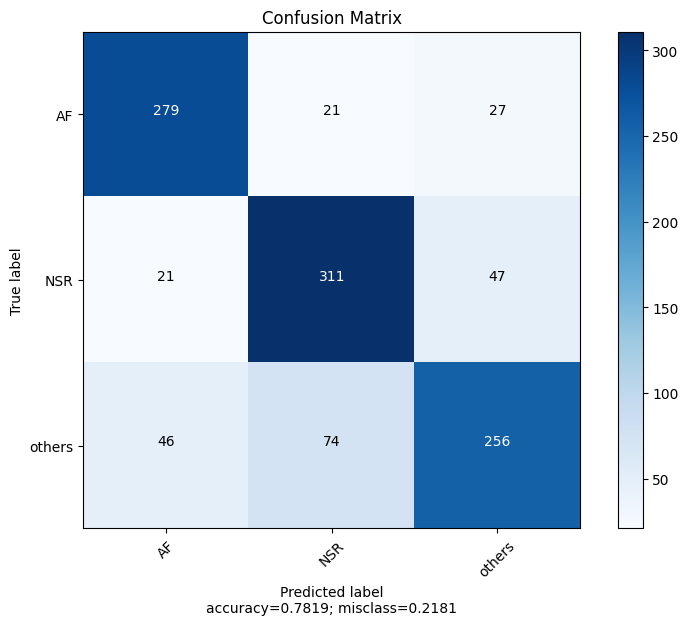

In [ ]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['AF','NSR','others'],
                      title        = "Confusion Matrix")

Fold 1


/usr/local/lib/python3.10/dist-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)


Epoch [1/10], Train Loss: 1.3541, Train Accuracy: 47.35%, Val Loss: 0.8729, Val Accuracy: 58.15%
Epoch [2/10], Train Loss: 0.8247, Train Accuracy: 61.61%, Val Loss: 0.7504, Val Accuracy: 67.63%
Epoch [3/10], Train Loss: 0.7452, Train Accuracy: 69.50%, Val Loss: 0.7342, Val Accuracy: 71.45%
Epoch [4/10], Train Loss: 0.7368, Train Accuracy: 68.95%, Val Loss: 0.6788, Val Accuracy: 73.29%
Epoch [5/10], Train Loss: 0.7029, Train Accuracy: 71.38%, Val Loss: 0.7350, Val Accuracy: 70.17%
Epoch [6/10], Train Loss: 0.7146, Train Accuracy: 70.22%, Val Loss: 0.7047, Val Accuracy: 70.75%
Epoch [7/10], Train Loss: 0.6413, Train Accuracy: 73.78%, Val Loss: 0.6732, Val Accuracy: 71.21%
Epoch [8/10], Train Loss: 0.6555, Train Accuracy: 73.69%, Val Loss: 0.6781, Val Accuracy: 72.95%
Epoch [9/10], Train Loss: 0.6857, Train Accuracy: 72.33%, Val Loss: 0.6755, Val Accuracy: 72.72%
Epoch [10/10], Train Loss: 0.9233, Train Accuracy: 58.11%, Val Loss: 0.9157, Val Accuracy: 56.99%


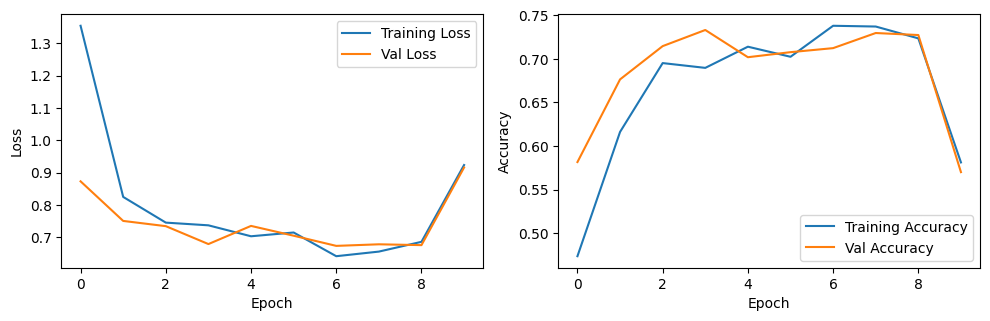

Fold 2
Epoch [1/10], Train Loss: 0.8107, Train Accuracy: 65.16%, Val Loss: 0.7304, Val Accuracy: 70.17%
Epoch [2/10], Train Loss: 0.7506, Train Accuracy: 68.69%, Val Loss: 0.6719, Val Accuracy: 73.87%
Epoch [3/10], Train Loss: 0.6950, Train Accuracy: 71.26%, Val Loss: 0.6754, Val Accuracy: 73.18%
Epoch [4/10], Train Loss: 0.6775, Train Accuracy: 71.75%, Val Loss: 0.7312, Val Accuracy: 68.44%
Epoch [5/10], Train Loss: 0.6655, Train Accuracy: 72.62%, Val Loss: 0.6702, Val Accuracy: 74.10%
Epoch [6/10], Train Loss: 0.6189, Train Accuracy: 75.17%, Val Loss: 0.6616, Val Accuracy: 73.18%
Epoch [7/10], Train Loss: 0.5981, Train Accuracy: 76.26%, Val Loss: 0.6798, Val Accuracy: 73.18%
Epoch [8/10], Train Loss: 0.5987, Train Accuracy: 76.12%, Val Loss: 0.6328, Val Accuracy: 74.10%
Epoch [9/10], Train Loss: 0.5787, Train Accuracy: 76.79%, Val Loss: 0.6665, Val Accuracy: 74.34%
Epoch [10/10], Train Loss: 0.5659, Train Accuracy: 77.10%, Val Loss: 0.6552, Val Accuracy: 74.80%


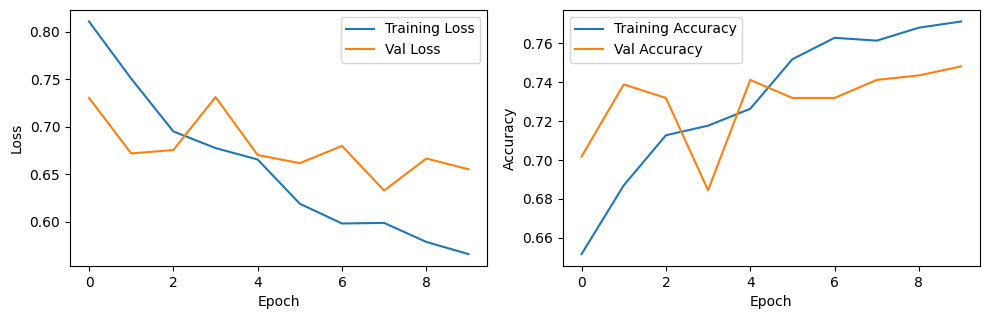

Fold 3
Epoch [1/10], Train Loss: 0.6395, Train Accuracy: 75.40%, Val Loss: 0.5189, Val Accuracy: 79.19%
Epoch [2/10], Train Loss: 0.5880, Train Accuracy: 77.22%, Val Loss: 0.5342, Val Accuracy: 78.50%
Epoch [3/10], Train Loss: 0.5838, Train Accuracy: 77.07%, Val Loss: 0.5931, Val Accuracy: 76.07%
Epoch [4/10], Train Loss: 0.6279, Train Accuracy: 75.05%, Val Loss: 0.5608, Val Accuracy: 77.57%
Epoch [5/10], Train Loss: 0.5626, Train Accuracy: 77.94%, Val Loss: 0.5608, Val Accuracy: 77.92%
Epoch [6/10], Train Loss: 0.5643, Train Accuracy: 78.23%, Val Loss: 0.6435, Val Accuracy: 73.53%
Epoch [7/10], Train Loss: 0.6456, Train Accuracy: 75.08%, Val Loss: 0.6279, Val Accuracy: 75.38%
Epoch [8/10], Train Loss: 0.5909, Train Accuracy: 77.48%, Val Loss: 0.5649, Val Accuracy: 77.46%
Epoch [9/10], Train Loss: 0.5570, Train Accuracy: 77.51%, Val Loss: 0.5907, Val Accuracy: 76.65%
Epoch [10/10], Train Loss: 0.5544, Train Accuracy: 77.94%, Val Loss: 0.5957, Val Accuracy: 76.88%


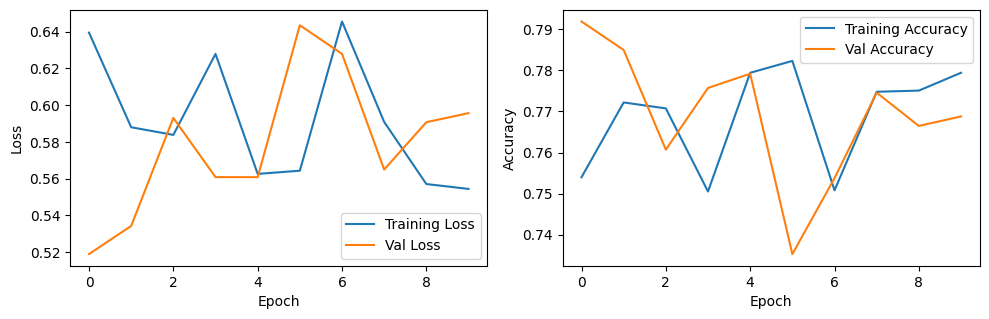

Fold 4
Epoch [1/10], Train Loss: 0.5417, Train Accuracy: 78.23%, Val Loss: 0.5272, Val Accuracy: 79.31%
Epoch [2/10], Train Loss: 0.5068, Train Accuracy: 79.56%, Val Loss: 0.5528, Val Accuracy: 78.50%
Epoch [3/10], Train Loss: 0.4946, Train Accuracy: 80.89%, Val Loss: 0.5955, Val Accuracy: 77.80%
Epoch [4/10], Train Loss: 0.5128, Train Accuracy: 80.14%, Val Loss: 0.6343, Val Accuracy: 75.61%
Epoch [5/10], Train Loss: 0.4891, Train Accuracy: 79.82%, Val Loss: 0.5526, Val Accuracy: 78.96%
Epoch [6/10], Train Loss: 0.4924, Train Accuracy: 79.94%, Val Loss: 0.5702, Val Accuracy: 78.84%
Epoch [7/10], Train Loss: 0.4388, Train Accuracy: 82.39%, Val Loss: 0.6046, Val Accuracy: 76.30%
Epoch [8/10], Train Loss: 0.4562, Train Accuracy: 82.34%, Val Loss: 0.6265, Val Accuracy: 76.99%
Epoch [9/10], Train Loss: 0.4497, Train Accuracy: 82.45%, Val Loss: 0.6265, Val Accuracy: 76.65%
Epoch [10/10], Train Loss: 0.4481, Train Accuracy: 82.05%, Val Loss: 0.6242, Val Accuracy: 76.53%


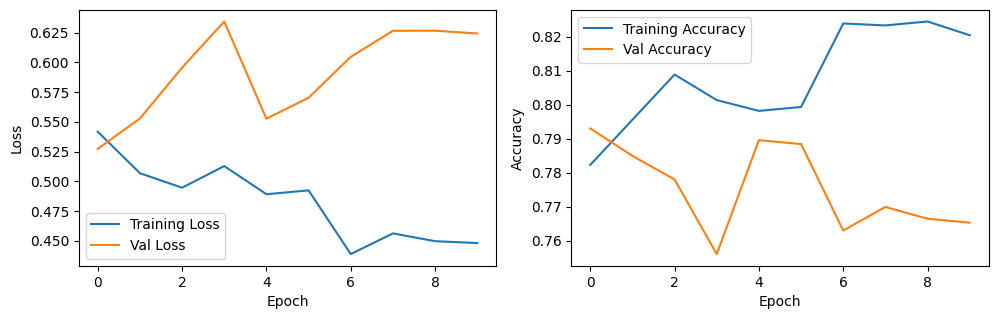

Fold 5
Epoch [1/10], Train Loss: 0.4771, Train Accuracy: 81.27%, Val Loss: 0.4207, Val Accuracy: 83.10%
Epoch [2/10], Train Loss: 0.4726, Train Accuracy: 81.42%, Val Loss: 0.4944, Val Accuracy: 80.56%
Epoch [3/10], Train Loss: 0.4683, Train Accuracy: 81.18%, Val Loss: 0.4547, Val Accuracy: 81.37%
Epoch [4/10], Train Loss: 0.4307, Train Accuracy: 82.40%, Val Loss: 0.4845, Val Accuracy: 79.05%
Epoch [5/10], Train Loss: 0.4143, Train Accuracy: 83.47%, Val Loss: 0.5024, Val Accuracy: 78.12%
Epoch [6/10], Train Loss: 0.4069, Train Accuracy: 84.10%, Val Loss: 0.4974, Val Accuracy: 79.40%
Epoch [7/10], Train Loss: 0.4203, Train Accuracy: 82.98%, Val Loss: 0.5423, Val Accuracy: 78.94%
Epoch [8/10], Train Loss: 0.4224, Train Accuracy: 84.28%, Val Loss: 0.5086, Val Accuracy: 79.51%
Epoch [9/10], Train Loss: 0.4898, Train Accuracy: 80.92%, Val Loss: 0.5258, Val Accuracy: 79.40%
Epoch [10/10], Train Loss: 0.4111, Train Accuracy: 83.96%, Val Loss: 0.5535, Val Accuracy: 78.94%


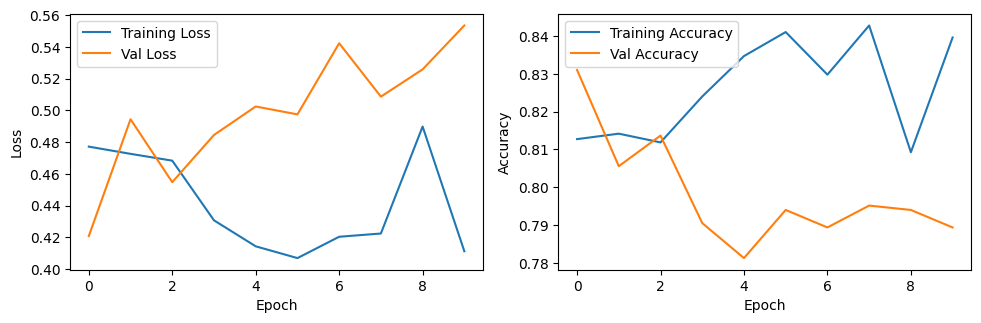

In [19]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
k_folds = 5
num_recordings = len(recording_files)
split_point = int(0.8 * num_recordings)

train_recording = recording_files[:split_point]
test_recording = recording_files[split_point:]
train_header = header_files[:split_point]
test_header = header_files[split_point:]
dataset = MyDataset(train_recording, train_header)
test_dataset = MyDataset(test_recording, test_header)
train_model(model, criterion, optimizer, num_epochs, k_folds, dataset)

In [20]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report
y_pred_list = []
y_true_list = []
testloader = DataLoader(test_dataset, batch_size=batch_size)
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

import numpy as np
y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)
print(classification_report(y_true, y_pred))

  0%|          | 0/17 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.82      0.77       344
           1       0.81      0.60      0.69       379
           2       0.58      0.69      0.63       359

    accuracy                           0.70      1082
   macro avg       0.71      0.70      0.70      1082
weighted avg       0.71      0.70      0.70      1082



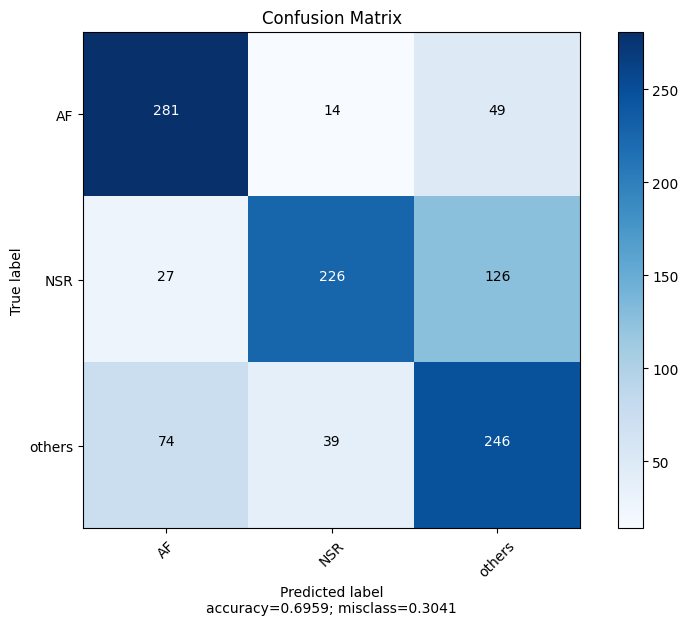

In [21]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm = cm,
                      normalize    = False,
                      target_names = ['AF','NSR','others'],
                      title        = "Confusion Matrix")